In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

import math  
import sys  
sys.path.append('C:/Users/j/hotai/myfolder')

from my_function import miscore, siscore
# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=5
startp=90
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1
file_tot=100
n=25
xstart=0
xend=25

In [2]:
def read_data(file_path,file_name,n,file_start=0,file_end=0,xstart=0,xend=0):
    x=np.zeros((121,n,n))
    y=np.zeros((121,n,n))
    vx=np.zeros((121,n,n))
    vy=np.zeros((121,n,n))
    for i in range(file_start,file_end):
        xp=[]
        yp=[]
        vxp=[]
        vyp=[]
        isvalid=[]
        xtmp=[]
        ytmp=[]
        vxtmp=[]
        vytmp=[]
        isvalidtmp=[]
        
        for root,dirs,files in os.walk(file_path):
            #print(root)
            
            for dir in dirs:
                #print(os.path.join(root,file))
                
    
                    with open(os.path.join(root,dir,file_name[i]), 'r') as f:  
                        lines = f.readlines()
                        for line in lines[3:]: 
                            num=line.split()
                            xtmp.append(float(num[0]))
                            ytmp.append(float(num[1]))
                            vxtmp.append(float(num[2]))
                            vytmp.append(float(num[3]))
                            isvalidtmp.append(float(num[4]))
        
                    xp.append(np.array(xtmp).reshape(25,25))
                    yp.append(np.array(ytmp).reshape(25,25))
                    vxp.append(np.array(vxtmp).reshape(25,25))
                    vyp.append(np.array(vytmp).reshape(25,25))
                    isvalid.append(np.array(isvalidtmp).reshape(25,25))
                    xtmp=[]
                    ytmp=[]
                    vxtmp=[]
                    vytmp=[]
                    isvalidtmp=[]
        #
        xp=np.array(xp)
        yp=np.array(yp)
        vxp=np.array(vxp)
        vyp=np.array(vyp)
        isvalid=np.array(isvalid)
        x=x+xp/file_tot
        y=y+yp/file_tot
        vx=vx+vxp/file_tot
        vy=vy+vyp/file_tot
    x=x.T
    x=x[xstart:xend,xstart:xend]
    y=y.T
    y=y[xstart:xend,xstart:xend]
    vx=vx.T
    vx=vx[xstart:xend,xstart:xend]
    vy=vy.T
    vy=vy[xstart:xend,xstart:xend]
    isvalid=isvalid.T
    isvalid=isvalid[xstart:xend,xstart:xend]
    return x,y,vx,vy

In [3]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C1_20')
file_name=['B00001.dat','B00002.dat','B00003.dat','B00004.dat','B00005.dat','B00006.dat','B00007.dat','B00008.dat',
           'B00009.dat','B00010.dat','B00011.dat','B00012.dat','B00013.dat','B00014.dat','B00015.dat','B00016.dat','B00017.dat',
           'B00018.dat','B00019.dat','B00020.dat','B00021.dat','B00022.dat','B00023.dat','B00024.dat','B00025.dat','B00026.dat',
           'B00027.dat','B00028.dat','B00029.dat','B00030.dat','B00031.dat','B00032.dat','B00033.dat','B00034.dat','B00035.dat',
           'B00036.dat','B00037.dat','B00038.dat','B00039.dat','B00040.dat','B00041.dat','B00042.dat','B00043.dat','B00044.dat',
           'B00045.dat','B00046.dat','B00047.dat','B00048.dat','B00049.dat','B00050.dat','B00051.dat','B00052.dat','B00053.dat',
           'B00054.dat','B00055.dat','B00056.dat','B00057.dat','B00058.dat','B00059.dat','B00060.dat','B00061.dat','B00062.dat',
           'B00063.dat','B00064.dat','B00065.dat','B00066.dat','B00067.dat','B00068.dat','B00069.dat','B00070.dat','B00071.dat',
           'B00072.dat','B00073.dat','B00074.dat','B00075.dat','B00076.dat','B00077.dat','B00078.dat','B00079.dat','B00080.dat',
           'B00081.dat','B00082.dat','B00083.dat','B00084.dat','B00085.dat','B00086.dat','B00087.dat','B00088.dat','B00089.dat',
           'B00090.dat','B00091.dat','B00092.dat','B00093.dat','B00094.dat','B00095.dat','B00096.dat','B00097.dat','B00098.dat',
           'B00099.dat','B00100.dat']
x=np.zeros((121,n,n))
y=np.zeros((121,n,n))
vx=np.zeros((121,n,n))
vy=np.zeros((121,n,n))

x,y,vx,vy=read_data(file_path,file_name,25,0,50,xstart,xend)
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=t[1]-t[0]

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

30
1


In [4]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=xend-xstart

t_in=np.zeros((n,n,dp))
for i in range (dp):
    t_in[:,:,i]=t[i]

print(t_in[0,0])

u=np.zeros((n,n,121, 3))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u[:, :, startp:endp, 2] = t_in
u_train=np.zeros((n,n,len(t), 3))
u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),3))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


[0.05625  0.056875 0.0575   0.058125 0.05875  0.059375 0.06     0.060625
 0.06125  0.061875 0.0625   0.063125 0.06375  0.064375 0.065    0.065625
 0.06625  0.066875 0.0675   0.068125 0.06875  0.069375 0.07     0.070625
 0.07125  0.071875 0.0725   0.073125 0.07375  0.074375]


<function matplotlib.pyplot.show(close=None, block=None)>

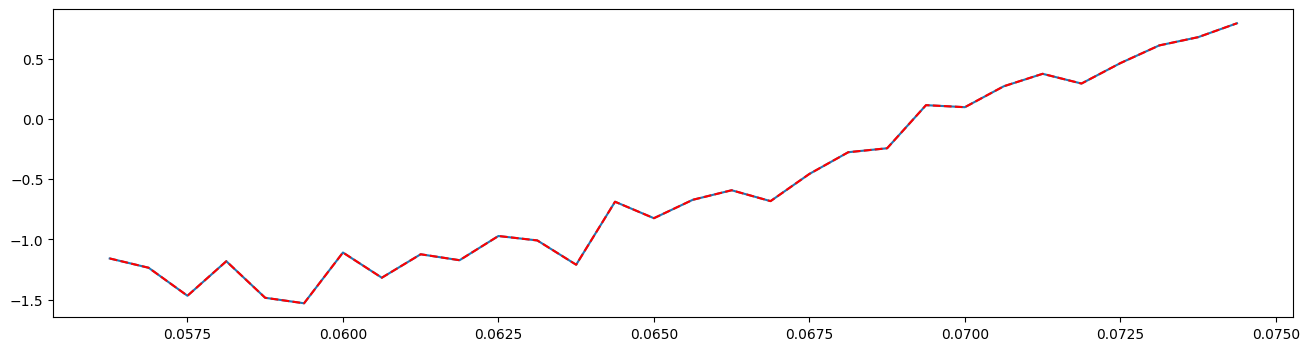

In [5]:
op=np.zeros(len(t))
op=u_train[10,10,:,0]
op_train=np.zeros(len(t_train))
for i in range(len(t)-1):
    for j in range(addp):
        op_train[i*addp+j]=(op[i]*(addp-j)+op[i+1]*j)/addp
op_train[-1]=op[-1]
plt.figure(figsize=(16, 4))
plt.plot(t,op)
plt.plot(t_train,op_train,'r--')
plt.show

In [6]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)
siscore(vtmp,v_train)
vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI(average/percent):
0.9847500486490925 0.9970835174547061
SI(average/percent):
0.9999999999999895 1.0
MI(average/percent):
0.9968037659232565 0.9993592576226248
SI(average/percent):
0.9993993713319234 1.0


(0.9993993713319234, 1.0)

In [7]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    periodic=True

library_functions = [
    lambda y: y,
    lambda x: x*x,
    
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x , y , z: x * y * z
]
library_function_names = [
    lambda y: y,
    lambda x: x+x,
    
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x , y , z: x + y + z
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True
    
)




print('SINDy')
model = ps.SINDy(feature_library=pde_lib, feature_names=['Vx','Vy','t'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)x_dot=v_train_dot
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])
model.fit(v_train, dt_train)
model.print()'''

SINDy
(Vx)' = -1879.059 1 + 43.354 Vx + 320.567 Vy + 56073.374 t + -129.394 VxVx + -440.291 VyVy + -410383.928 tt + 107.754 VxVy + -180.000 Vxt + -4939.063 Vyt + -30.477 VxVxVy + 2934.047 VxVxt + 6972.315 VyVyt + -2033.898 VxVyt + -755.146 Vx_2 + -372.906 Vy_2 + 1293.798 Vx_1 + 4589.444 Vy_1 + 505.690 VxVx_2 + -135.897 VxVy_2 + 15148.633 Vxt_2 + 226.236 VyVx_2 + 220.497 VyVy_2 + -28900.203 Vyt_2 + -546.163 tVx_2 + -7355.244 tVy_2 + 2014.361 tt_2 + -89.509 VxVxVx_2 + -2708.234 VxVxVy_2 + -3713.929 VxVxt_2 + 7464.846 VyVyVx_2 + 1129.263 VyVyVy_2 + -736.505 VyVyt_2 + 11902.790 ttVx_2 + -467.526 ttVy_2 + 830.654 ttt_2 + -94655.655 VxVyVx_2 + -629.387 VxVyVy_2 + -16541.853 VxVyt_2 + 9189.891 VxtVx_2 + -33.725 VxtVy_2 + 9387.144 Vxtt_2 + -11755.700 VytVx_2 + 9120.144 VytVy_2 + 690.113 VxVx_1 + -2485.032 VxVy_1 + -43511.624 Vxt_1 + -64.828 VyVx_1 + 1781.792 VyVy_1 + 356364.188 Vyt_1 + -1688.171 tVx_1 + -11909.540 tVy_1 + 40269.519 tt_1 + -51.801 VxVxVx_1 + 1452.679 VxVxVy_1 + -28381.365 VxVxt

"\nprint('STLSQ model: ')\noptimizer = ps.STLSQ(threshold=50, alpha=1e-5, \n                     normalize_columns=True, max_iter=200)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy','t'])\nmodel.fit(v_train, dt_train)\nmodel.print()"

In [8]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: -7.272956
Model score: -22.625429
Model score: 0.166911
Model score: 0.216070


In [9]:
x_test,y_test,vx_test,vy_test=read_data(file_path,file_name,25,50,100,xstart,xend)


t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]

si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)
si_t_per=np.zeros(p_tot)
mi_t_per=np.zeros(p_tot)

In [10]:
#u is not pre adding, v add a median


n=xend-xstart


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test

u_test=np.zeros((n,n,len(t), 3))
u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),3))
for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]


In [11]:
x_dot_test_predicted = model.predict(v_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(n,n,p_tot,3)
tlen=len(t_train)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
#print(dot_tmp[10,10])

In [12]:
print('add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201')
print('add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588')
print('add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543')
print('add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524')
print('add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714')

pltpredict[:,:,0]=v_train[:,:,0,:2]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i,:2]*dt_train
miscore(pltpredict,v_test)
siscore(pltpredict,v_test)
#print(pltpredict[10,10])
#print(v_train[10,10])

add 7 point, from 80 to 120, with library x^3, derivative order 2, MI:0.6748241001379309, SI:0.8570345301079201
add 7 point, from 80 to 120, with library x^3, derivative order 1, MI:0.6732771082529756, SI:0.8589308511150588
add 7 point, from 80 to 120, with library x^2, derivative order 2, MI:0.6707939885275049, SI:0.8459658232811543
add 7 point, from 80 to 120, with library x^2, derivative order 1, MI:0.6693806511354194, SI:0.8426666431380524
add 7 point, from 90 to 120, with library x^2, derivative order 1, MI:0.6709005447980256, SI:0.8424080789942714
MI(average/percent):
0.8364347790920799 0.7254750331418471
SI(average/percent):
0.9312756089715136 0.9032258064516129


(0.9312756089715136, 0.9032258064516129)

0
MI(average/percent):
0.8854544849264636 0.8451612903225807
SI(average/percent):
0.9285915575647687 0.8935483870967742


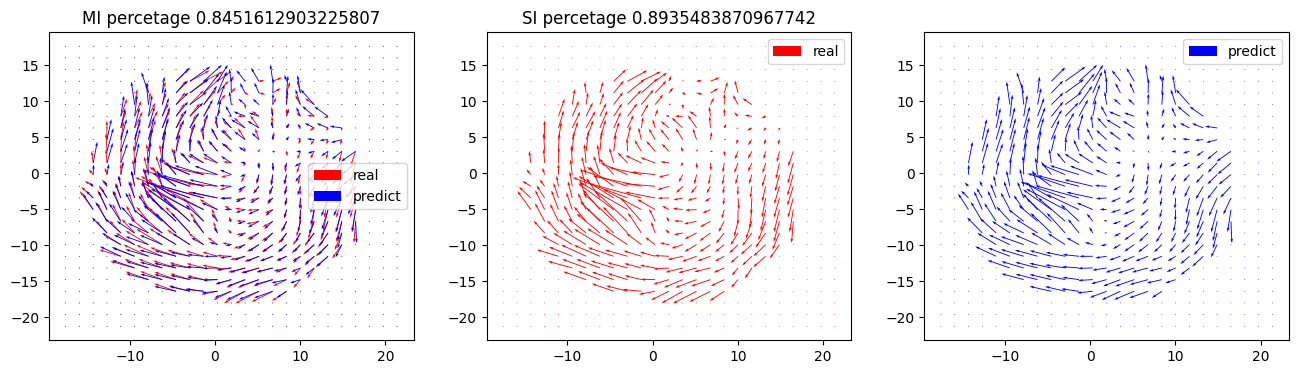

1
MI(average/percent):
0.8906706039678203 0.864516129032258
SI(average/percent):
0.9339596603782595 0.9129032258064517
2
MI(average/percent):
0.892415651848128 0.8709677419354839
SI(average/percent):
0.9367319405497503 0.9096774193548387
3
MI(average/percent):
0.8897183839876047 0.8709677419354839
SI(average/percent):
0.9390357942643547 0.9129032258064517
4
MI(average/percent):
0.8848718966905474 0.8451612903225807
SI(average/percent):
0.938275360311998 0.9161290322580645
5
MI(average/percent):
0.8766594056317611 0.8258064516129032
SI(average/percent):
0.9387594761026988 0.9161290322580645


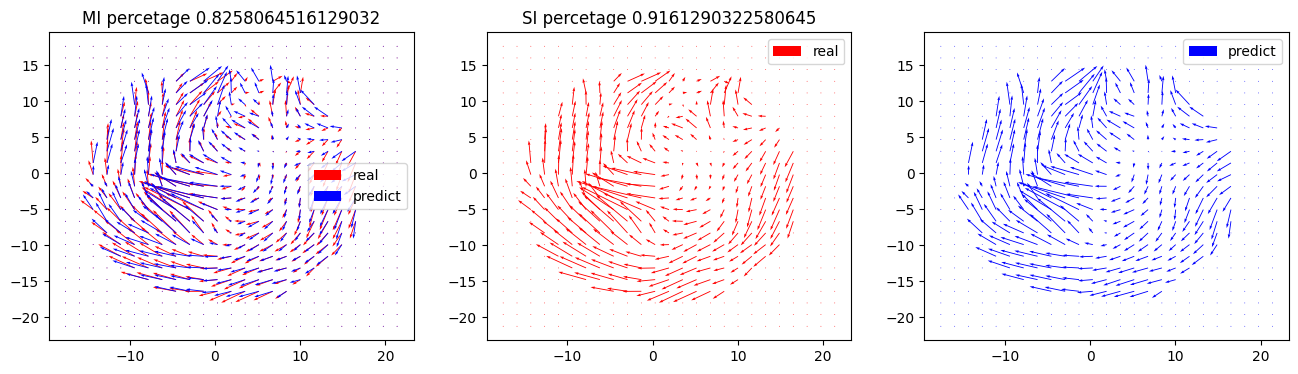

6
MI(average/percent):
0.8850967589118771 0.8451612903225807
SI(average/percent):
0.9415871602528141 0.9354838709677419
7
MI(average/percent):
0.8921838234397048 0.8548387096774194
SI(average/percent):
0.9443658520100711 0.932258064516129
8
MI(average/percent):
0.8972988984533028 0.864516129032258
SI(average/percent):
0.9445571571440181 0.9290322580645162
9
MI(average/percent):
0.899963313940387 0.8709677419354839
SI(average/percent):
0.9441955531033233 0.9290322580645162
10
MI(average/percent):
0.8993180677645702 0.8741935483870967
SI(average/percent):
0.9415102956262406 0.9258064516129032


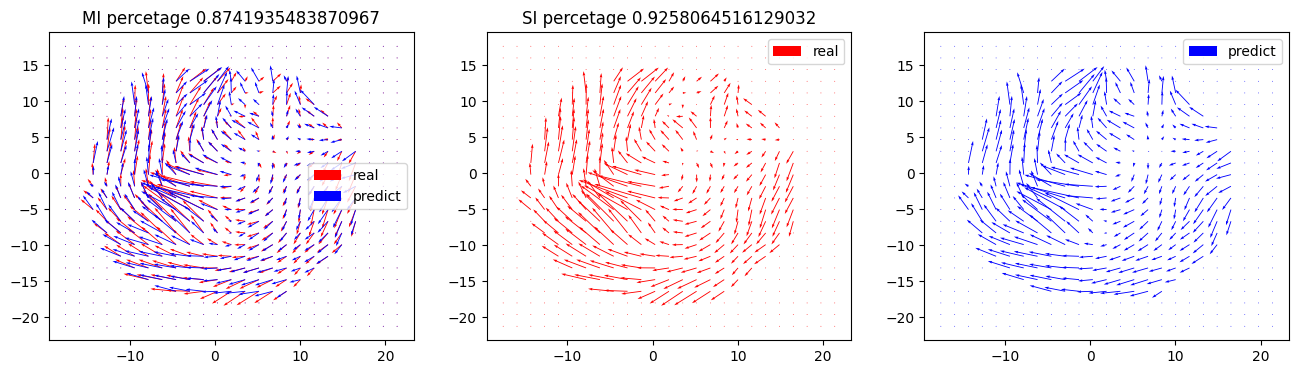

11
MI(average/percent):
0.897840932477723 0.8709677419354839
SI(average/percent):
0.9437689251366964 0.9290322580645162
12
MI(average/percent):
0.895675037369583 0.867741935483871
SI(average/percent):
0.9431853812321225 0.9258064516129032
13
MI(average/percent):
0.8921890287246862 0.8387096774193549
SI(average/percent):
0.940303933504361 0.9193548387096774
14
MI(average/percent):
0.887458313400315 0.832258064516129
SI(average/percent):
0.9349299203558692 0.9161290322580645
15
MI(average/percent):
0.8800452099730007 0.8290322580645161
SI(average/percent):
0.9250384255880525 0.9032258064516129


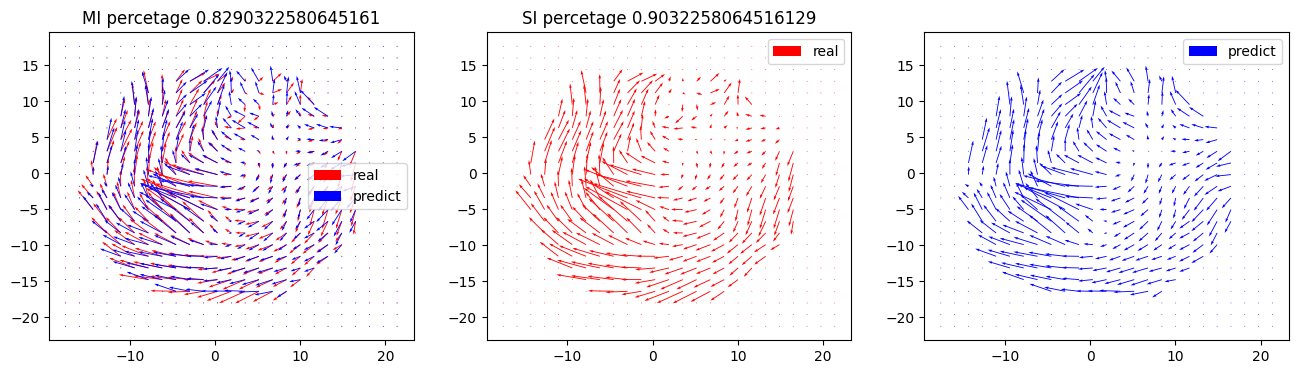

16
MI(average/percent):
0.8865958932046245 0.8451612903225807
SI(average/percent):
0.9302962866798256 0.9032258064516129
17
MI(average/percent):
0.891340018629057 0.8419354838709677
SI(average/percent):
0.9358471967332359 0.9032258064516129
18
MI(average/percent):
0.894254777475905 0.8516129032258064
SI(average/percent):
0.9374786293197356 0.9032258064516129
19
MI(average/percent):
0.8931957203273775 0.8580645161290322
SI(average/percent):
0.9335696604587617 0.9096774193548387
20
MI(average/percent):
0.8905959210168841 0.8709677419354839
SI(average/percent):
0.9326498598886045 0.896774193548387


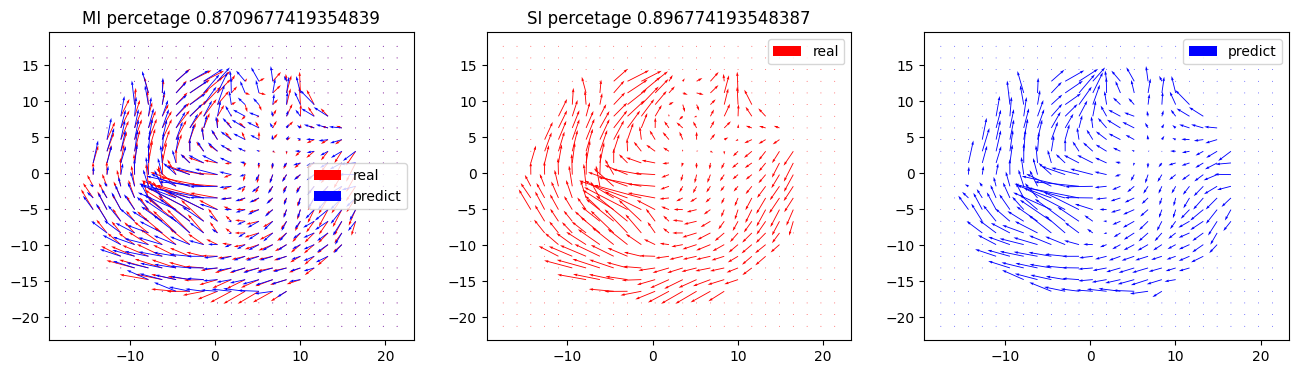

21
MI(average/percent):
0.8965845683626472 0.8774193548387097
SI(average/percent):
0.9377589645605802 0.9225806451612903
22
MI(average/percent):
0.9000913775879953 0.8806451612903226
SI(average/percent):
0.94039955555239 0.9225806451612903
23
MI(average/percent):
0.900099936582601 0.867741935483871
SI(average/percent):
0.9407306932493169 0.9129032258064517
24
MI(average/percent):
0.8978521533250614 0.8709677419354839
SI(average/percent):
0.9394652307144659 0.9161290322580645
25
MI(average/percent):
0.8947409372033672 0.8580645161290322
SI(average/percent):
0.9357112274058039 0.9161290322580645


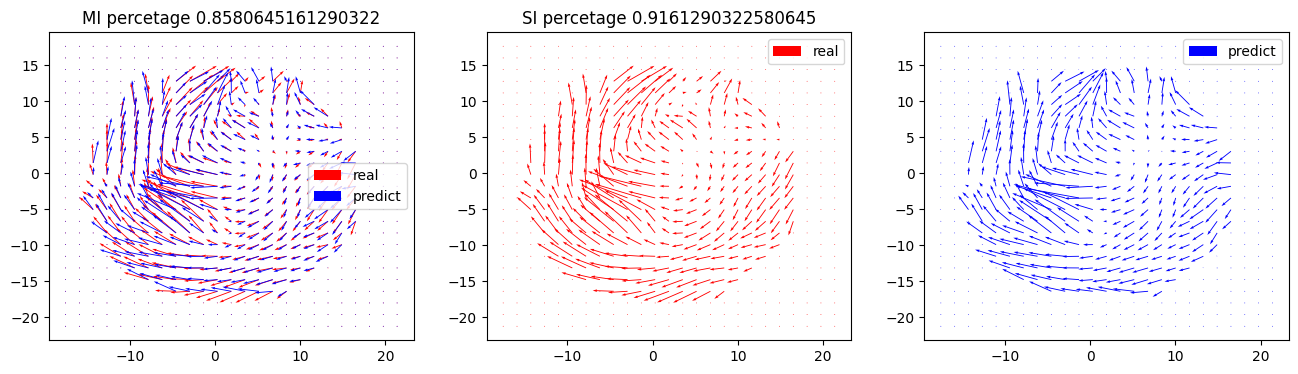

26
MI(average/percent):
0.8960758024545645 0.8580645161290322
SI(average/percent):
0.9408814237260221 0.932258064516129
27
MI(average/percent):
0.8964730605421222 0.8709677419354839
SI(average/percent):
0.9413504980978411 0.932258064516129
28
MI(average/percent):
0.8958143028934542 0.867741935483871
SI(average/percent):
0.9418802860616464 0.9225806451612903
29
MI(average/percent):
0.8929548959644291 0.8580645161290322
SI(average/percent):
0.9403491012732615 0.9161290322580645
30
MI(average/percent):
0.8883097230634426 0.8451612903225807
SI(average/percent):
0.9367317563717374 0.9193548387096774


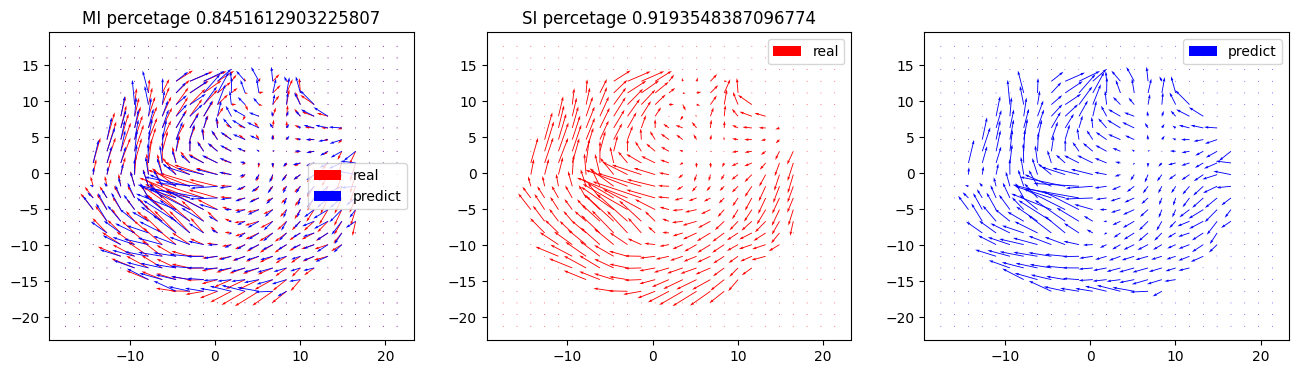

31
MI(average/percent):
0.8925475379012953 0.8580645161290322
SI(average/percent):
0.9340579491675676 0.9161290322580645
32
MI(average/percent):
0.8943635098048331 0.8741935483870967
SI(average/percent):
0.9347761200563958 0.9161290322580645
33
MI(average/percent):
0.8919897123171605 0.8709677419354839
SI(average/percent):
0.9355120628416401 0.9129032258064517
34
MI(average/percent):
0.8883995705248289 0.8548387096774194
SI(average/percent):
0.9314868552499148 0.9
35
MI(average/percent):
0.8834602638165736 0.8516129032258064
SI(average/percent):
0.924931970041354 0.8935483870967742


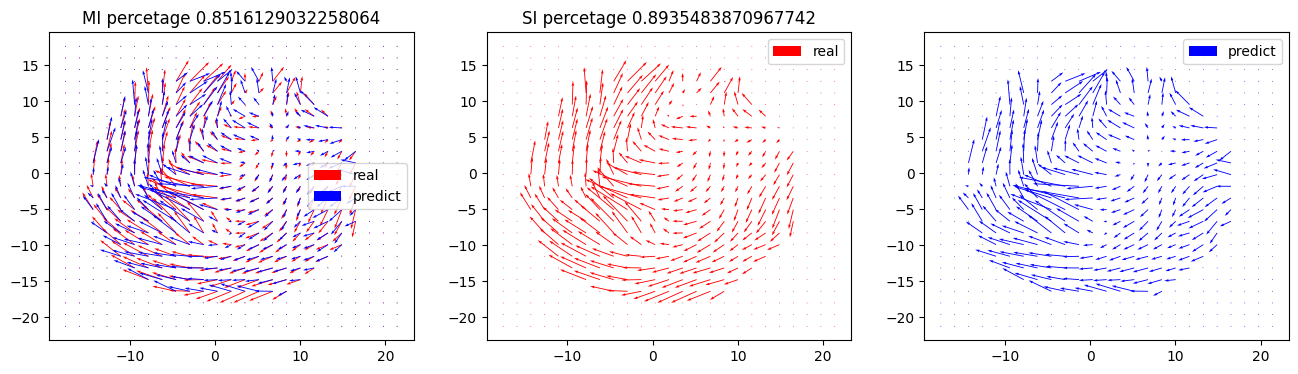

36
MI(average/percent):
0.8853123046145794 0.8516129032258064
SI(average/percent):
0.9283612293108701 0.896774193548387
37
MI(average/percent):
0.8862198679698194 0.8612903225806452
SI(average/percent):
0.928870012293863 0.8935483870967742
38
MI(average/percent):
0.8839209602881505 0.8483870967741935
SI(average/percent):
0.9271129611337764 0.8870967741935484
39
MI(average/percent):
0.8780223990459495 0.832258064516129
SI(average/percent):
0.9236856445798713 0.8935483870967742
40
MI(average/percent):
0.8691837981824211 0.8193548387096774
SI(average/percent):
0.9176538893320803 0.8806451612903226


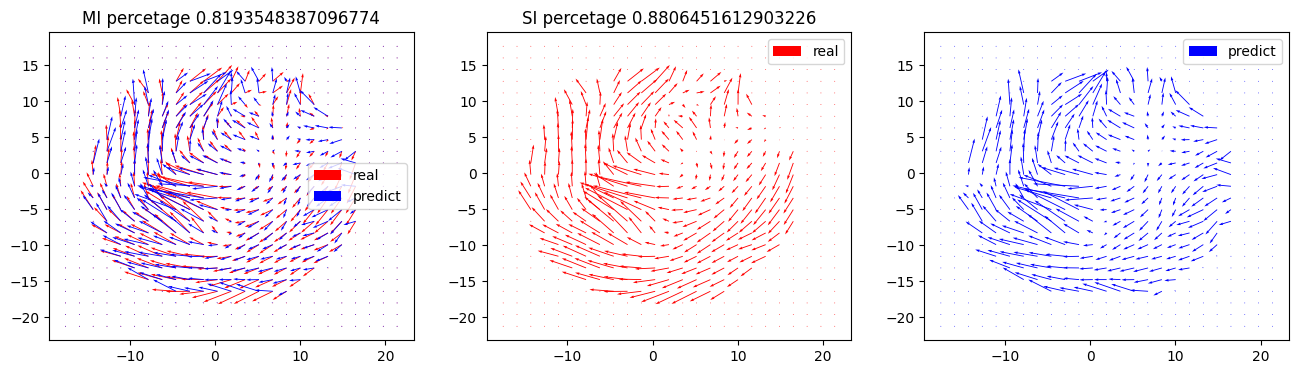

41
MI(average/percent):
0.8768620614924301 0.8290322580645161
SI(average/percent):
0.9199881819167395 0.8838709677419355
42
MI(average/percent):
0.8823845774106732 0.8451612903225807
SI(average/percent):
0.9211291534956195 0.9
43
MI(average/percent):
0.8851399905008294 0.8387096774193549
SI(average/percent):
0.9197521193591807 0.8903225806451613
44
MI(average/percent):
0.8859753268782496 0.8419354838709677
SI(average/percent):
0.9150925515047774 0.8709677419354839
45
MI(average/percent):
0.884299386717174 0.8419354838709677
SI(average/percent):
0.907075125055582 0.8548387096774194


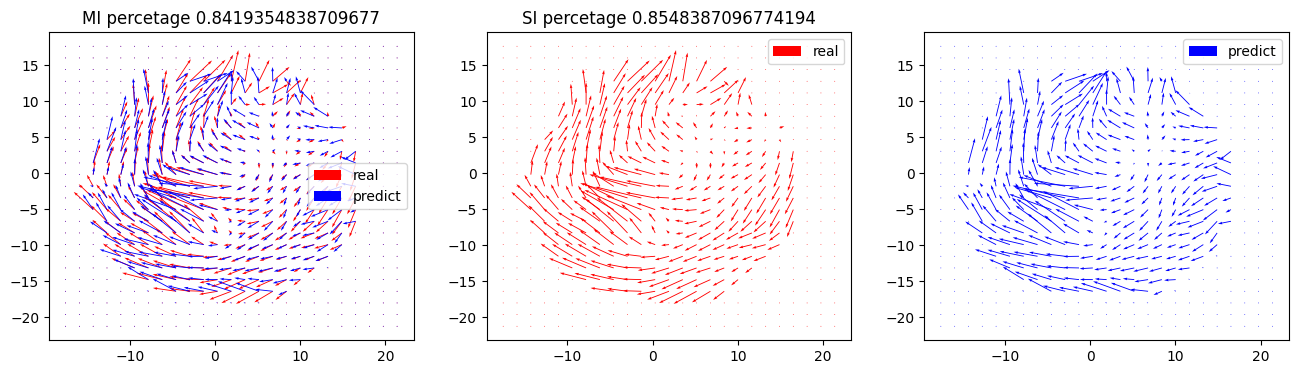

46
MI(average/percent):
0.8847089841593103 0.8387096774193549
SI(average/percent):
0.9080895427946671 0.8580645161290322
47
MI(average/percent):
0.8833549713358392 0.8290322580645161
SI(average/percent):
0.9095398641131706 0.864516129032258
48
MI(average/percent):
0.8799109602771374 0.8193548387096774
SI(average/percent):
0.9062880547781736 0.8580645161290322
49
MI(average/percent):
0.8746484156011749 0.8129032258064516
SI(average/percent):
0.9022332629466375 0.8548387096774194
50
MI(average/percent):
0.8681405467217168 0.8064516129032258
SI(average/percent):
0.896128387183707 0.8548387096774194


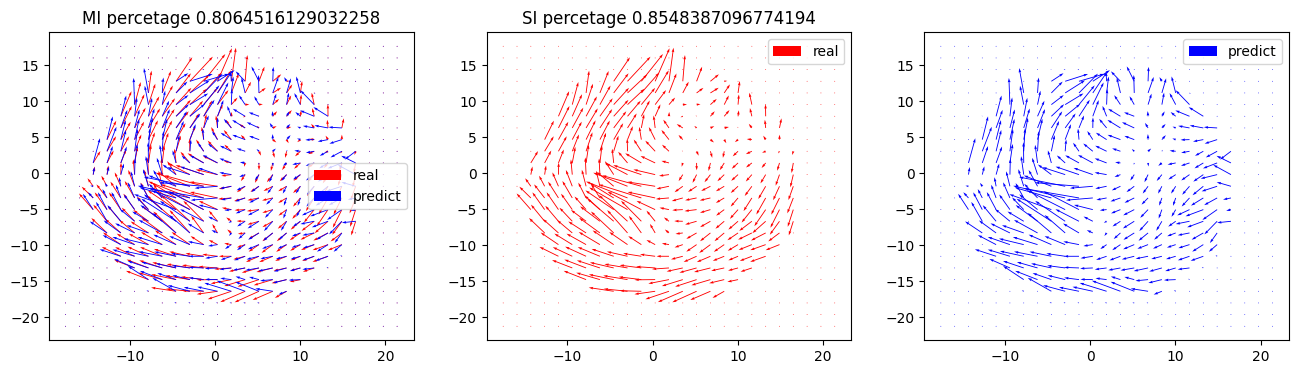

51
MI(average/percent):
0.868801046649153 0.8064516129032258
SI(average/percent):
0.9004697845673393 0.8451612903225807
52
MI(average/percent):
0.8674297373954316 0.8
SI(average/percent):
0.9009527490945958 0.8354838709677419
53
MI(average/percent):
0.8632185224307254 0.7935483870967742
SI(average/percent):
0.9001555208985054 0.832258064516129
54
MI(average/percent):
0.85714189638742 0.7774193548387097
SI(average/percent):
0.8998340392827123 0.8387096774193549
55
MI(average/percent):
0.8488407637108191 0.7516129032258064
SI(average/percent):
0.897234643297649 0.8483870967741935


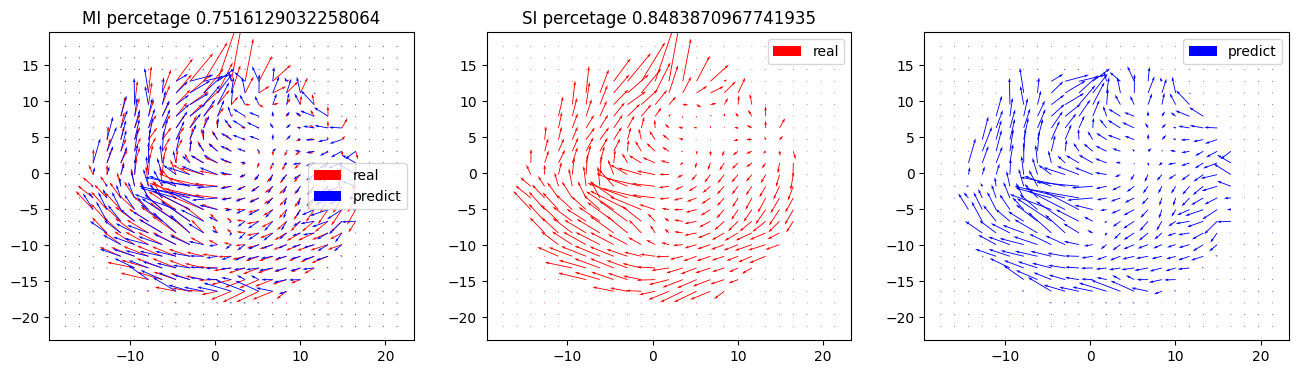

56
MI(average/percent):
0.8504914129743064 0.7580645161290323
SI(average/percent):
0.8969440405460404 0.8516129032258064
57
MI(average/percent):
0.8509781870993671 0.7516129032258064
SI(average/percent):
0.8946599524342073 0.8387096774193549
58
MI(average/percent):
0.8494897987885979 0.7548387096774194
SI(average/percent):
0.8905871347120461 0.8419354838709677
59
MI(average/percent):
0.8460935440554505 0.7516129032258064
SI(average/percent):
0.8873932132477781 0.832258064516129
60
MI(average/percent):
0.841075171001922 0.7419354838709677
SI(average/percent):
0.8804008281967995 0.8258064516129032


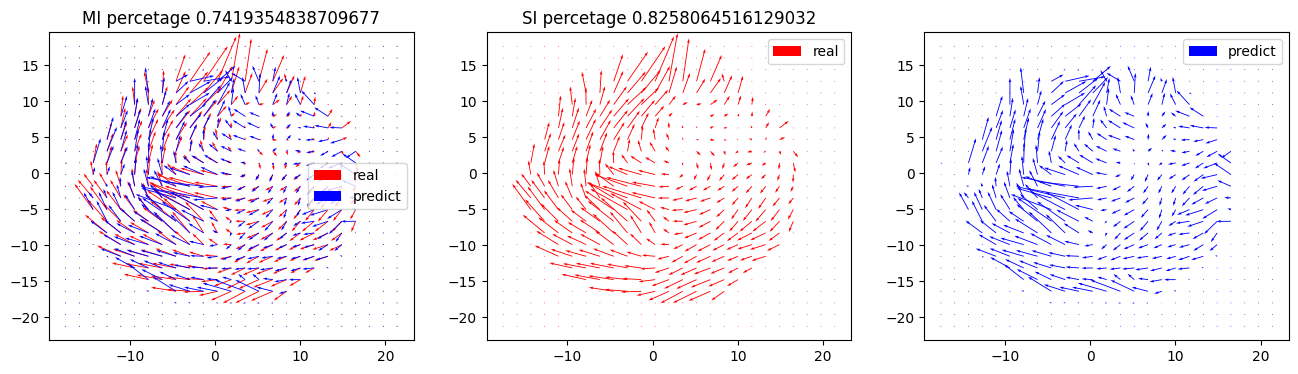

61
MI(average/percent):
0.8470680899494046 0.7419354838709677
SI(average/percent):
0.8817899863350624 0.8258064516129032
62
MI(average/percent):
0.8511172750016536 0.7548387096774194
SI(average/percent):
0.8806233738628846 0.8225806451612904
63
MI(average/percent):
0.8538792326601227 0.7548387096774194
SI(average/percent):
0.882099733834393 0.8354838709677419
64
MI(average/percent):
0.8542736356474379 0.7709677419354839
SI(average/percent):
0.8804930818350204 0.8258064516129032
65
MI(average/percent):
0.8519763353923612 0.7677419354838709
SI(average/percent):
0.8794044356037014 0.8258064516129032


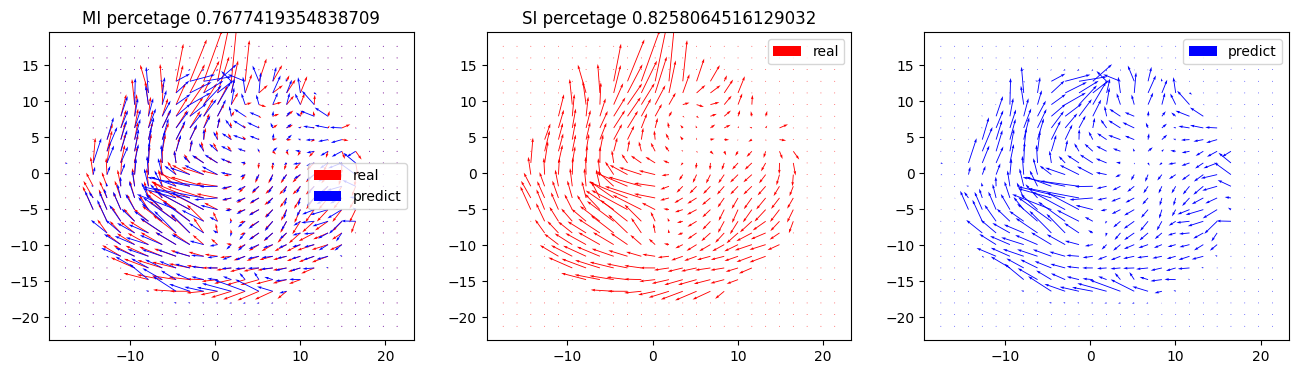

66
MI(average/percent):
0.8541709123434262 0.7645161290322581
SI(average/percent):
0.8828494189577111 0.832258064516129
67
MI(average/percent):
0.8538760420055169 0.7645161290322581
SI(average/percent):
0.885891355871062 0.8290322580645161
68
MI(average/percent):
0.8517786334808439 0.7709677419354839
SI(average/percent):
0.8879975512918008 0.8354838709677419
69
MI(average/percent):
0.8491240431345982 0.7612903225806451
SI(average/percent):
0.8858702746001968 0.832258064516129
70
MI(average/percent):
0.8458901366136199 0.7612903225806451
SI(average/percent):
0.8816806095158851 0.8258064516129032


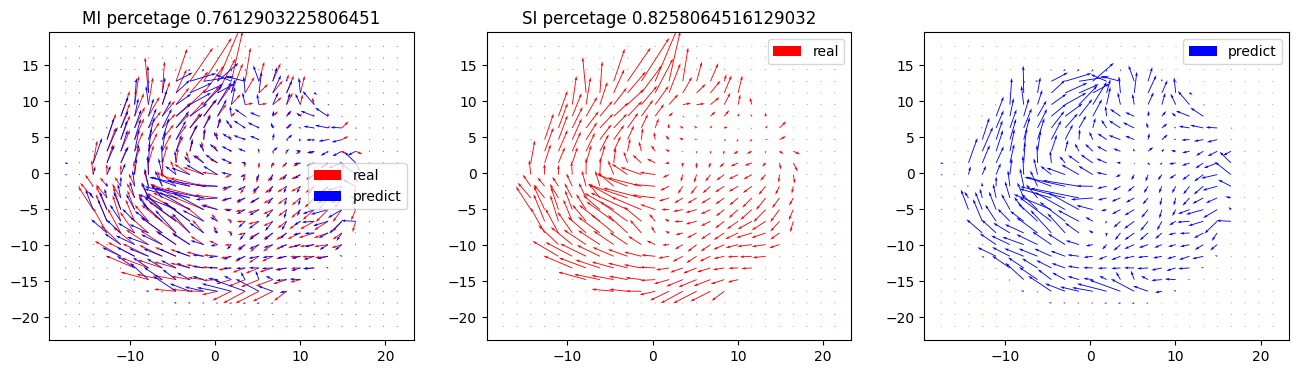

71
MI(average/percent):
0.8479301346684858 0.7612903225806451
SI(average/percent):
0.8834431891658081 0.8419354838709677
72
MI(average/percent):
0.8476451005324926 0.7516129032258064
SI(average/percent):
0.8816479944777285 0.8354838709677419
73
MI(average/percent):
0.8454636978258683 0.7516129032258064
SI(average/percent):
0.8804178802870481 0.8354838709677419
74
MI(average/percent):
0.842371572643396 0.7387096774193549
SI(average/percent):
0.8764486844060637 0.832258064516129
75
MI(average/percent):
0.8392605306498512 0.7354838709677419
SI(average/percent):
0.8549045614795238 0.8096774193548387


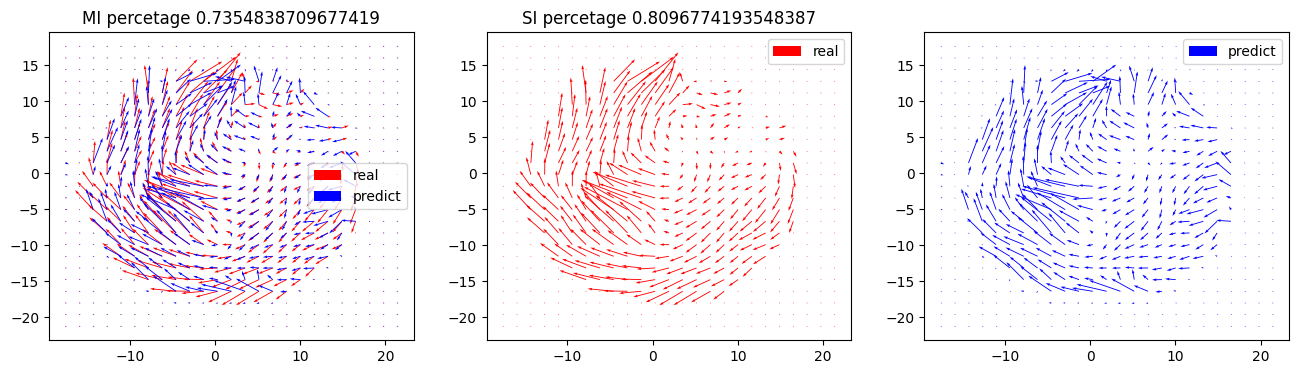

76
MI(average/percent):
0.836709723292188 0.7451612903225806
SI(average/percent):
0.8572831124431901 0.8064516129032258
77
MI(average/percent):
0.8364469090144305 0.7483870967741936
SI(average/percent):
0.8535753306411306 0.7903225806451613
78
MI(average/percent):
0.8325429819683122 0.7354838709677419
SI(average/percent):
0.8495670460359477 0.7838709677419354
79
MI(average/percent):
0.8289494321569898 0.7193548387096774
SI(average/percent):
0.8434997547639308 0.7774193548387097
80
MI(average/percent):
0.8253649559693559 0.6935483870967742
SI(average/percent):
0.8445669685274219 0.7774193548387097


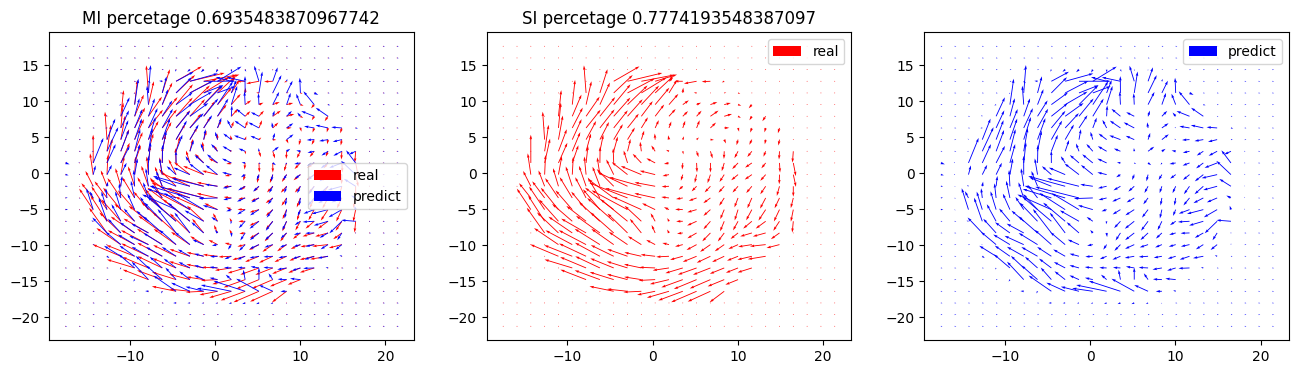

81
MI(average/percent):
0.8278750214026992 0.7064516129032258
SI(average/percent):
0.8546873314605198 0.7870967741935484
82
MI(average/percent):
0.8305995536655165 0.7193548387096774
SI(average/percent):
0.8588266853157377 0.7967741935483871
83
MI(average/percent):
0.8319829413949087 0.7
SI(average/percent):
0.8578595586858508 0.8
84
MI(average/percent):
0.8326974492144582 0.6935483870967742
SI(average/percent):
0.8574250113504525 0.7903225806451613
85
MI(average/percent):
0.8318085859904393 0.7
SI(average/percent):
0.8555172909261193 0.7774193548387097


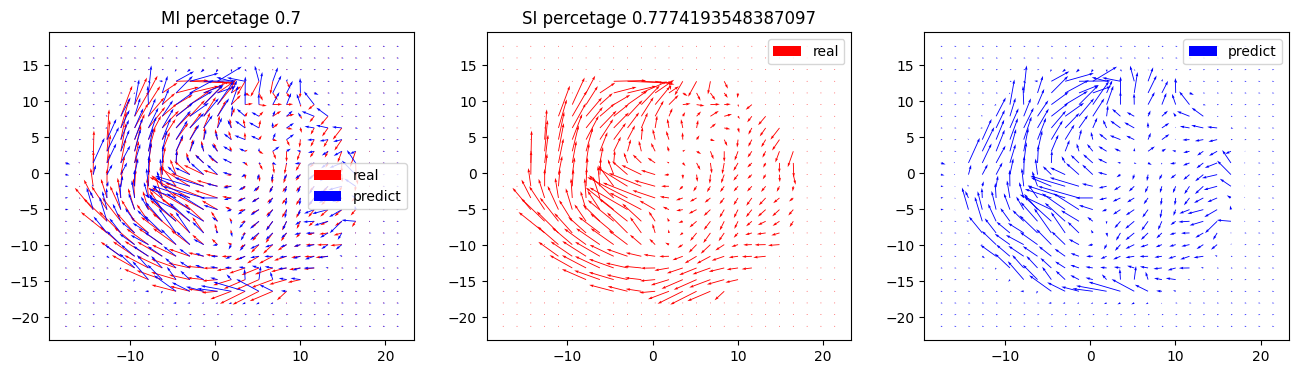

86
MI(average/percent):
0.8344502519893702 0.6967741935483871
SI(average/percent):
0.8499107315146454 0.7709677419354839
87
MI(average/percent):
0.8354413533017951 0.7
SI(average/percent):
0.8439460166047024 0.7580645161290323
88
MI(average/percent):
0.8357215357782757 0.7096774193548387
SI(average/percent):
0.8368058474414145 0.7483870967741936
89
MI(average/percent):
0.8342279514966962 0.7161290322580646
SI(average/percent):
0.8285578634574439 0.7419354838709677
90
MI(average/percent):
0.8319700796948304 0.7064516129032258
SI(average/percent):
0.8206568888587562 0.7322580645161291


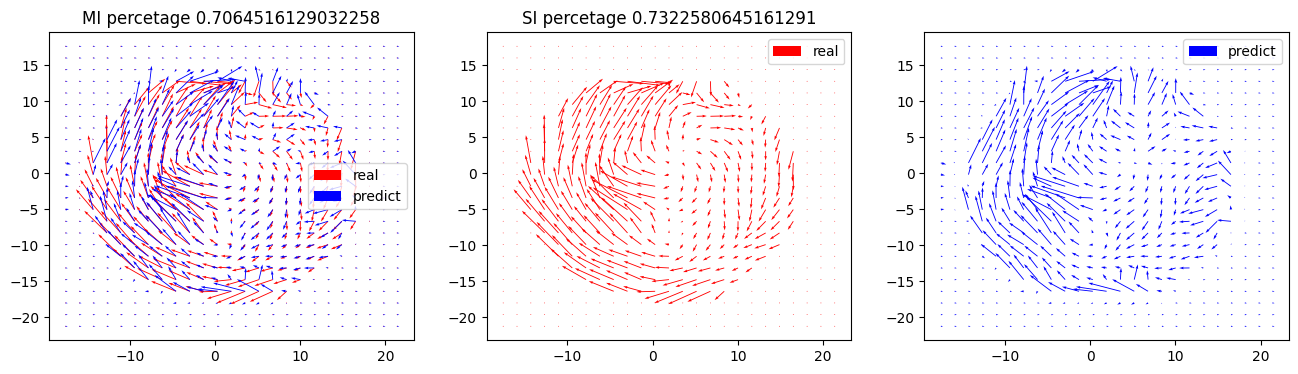

91
MI(average/percent):
0.8275268362614647 0.6903225806451613
SI(average/percent):
0.8195355026447566 0.7225806451612903
92
MI(average/percent):
0.8223039338313017 0.6838709677419355
SI(average/percent):
0.8162822146787181 0.7161290322580646
93
MI(average/percent):
0.8169046111718039 0.6548387096774193
SI(average/percent):
0.8141281343217405 0.7129032258064516
94
MI(average/percent):
0.81173732615023 0.6387096774193548
SI(average/percent):
0.8108276310577185 0.6967741935483871
95
MI(average/percent):
0.8077370141459731 0.635483870967742
SI(average/percent):
0.805812386515849 0.6709677419354839


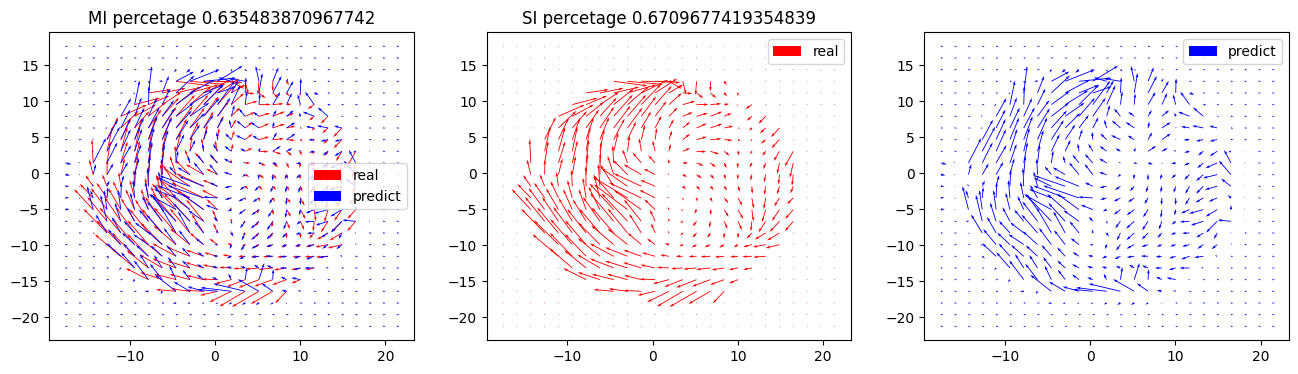

96
MI(average/percent):
0.8059433931048731 0.6419354838709678
SI(average/percent):
0.7963476885741698 0.6451612903225806
97
MI(average/percent):
0.8049369901352588 0.6483870967741936
SI(average/percent):
0.7860495815518116 0.6483870967741936
98
MI(average/percent):
0.8045840585383961 0.6451612903225806
SI(average/percent):
0.7800386815549861 0.632258064516129
99
MI(average/percent):
0.8048694310469031 0.6451612903225806
SI(average/percent):
0.7740955397462684 0.632258064516129
100
MI(average/percent):
0.8035793916598979 0.635483870967742
SI(average/percent):
0.7683427232932826 0.632258064516129


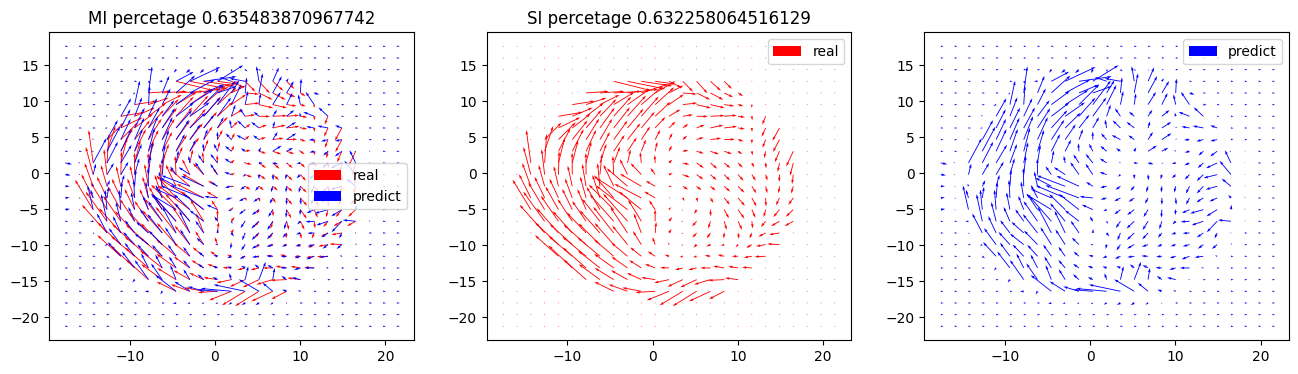

101
MI(average/percent):
0.8026637532752934 0.6387096774193548
SI(average/percent):
0.7625650831525804 0.6129032258064516
102
MI(average/percent):
0.8039152349003881 0.6483870967741936
SI(average/percent):
0.7613195072124066 0.6129032258064516
103
MI(average/percent):
0.8048322309289796 0.6419354838709678
SI(average/percent):
0.7610671832986526 0.6161290322580645
104
MI(average/percent):
0.8049368504441619 0.632258064516129
SI(average/percent):
0.7620721143663548 0.6193548387096774
105
MI(average/percent):
0.8048288231689474 0.6193548387096774
SI(average/percent):
0.7614494937401695 0.6258064516129033


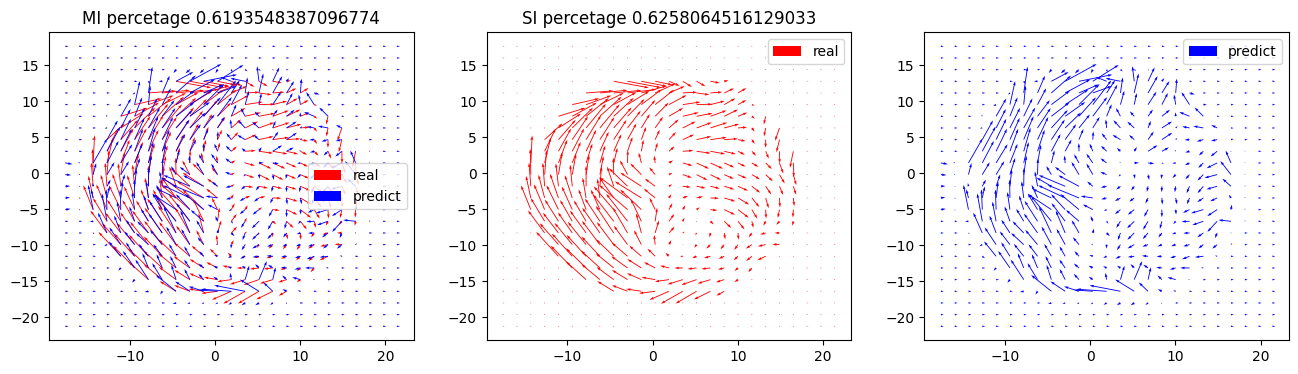

106
MI(average/percent):
0.8052019764041172 0.6258064516129033
SI(average/percent):
0.7617086084206539 0.6129032258064516
107
MI(average/percent):
0.8045442976612015 0.6258064516129033
SI(average/percent):
0.7539112454819847 0.6064516129032258
108
MI(average/percent):
0.8048818772896424 0.632258064516129
SI(average/percent):
0.7494292304962648 0.6064516129032258
109
MI(average/percent):
0.8056116629408231 0.6258064516129033
SI(average/percent):
0.7434974394076969 0.6129032258064516
110
MI(average/percent):
0.8062122655682017 0.6387096774193548
SI(average/percent):
0.7427951731082013 0.6


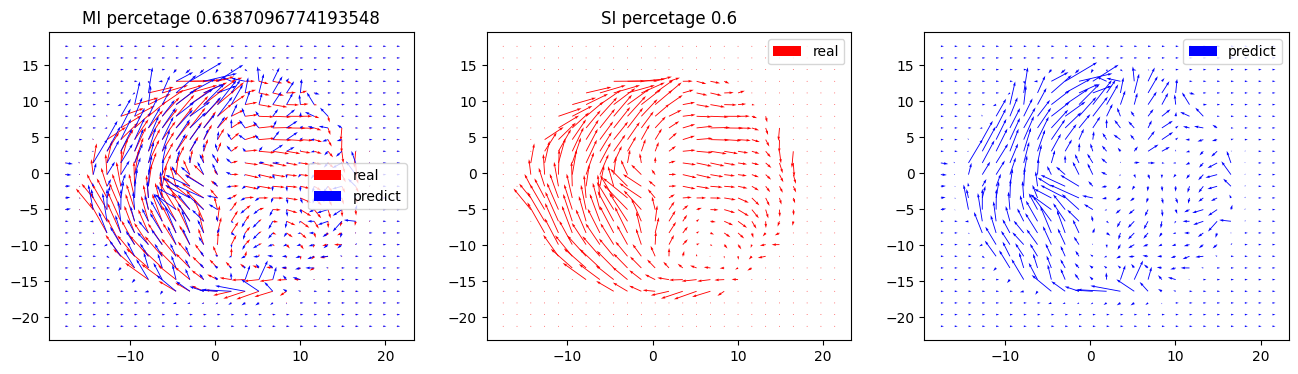

111
MI(average/percent):
0.8053647459821397 0.6290322580645161
SI(average/percent):
0.7479118963546906 0.6064516129032258
112
MI(average/percent):
0.8040656244244098 0.6193548387096774
SI(average/percent):
0.7544992078014516 0.6161290322580645
113
MI(average/percent):
0.802889600484296 0.6064516129032258
SI(average/percent):
0.7589679297458644 0.6258064516129033
114
MI(average/percent):
0.8007281194341049 0.6
SI(average/percent):
0.757633528001787 0.6258064516129033
115
MI(average/percent):
0.7976580374410378 0.5935483870967742
SI(average/percent):
0.7552871055680426 0.6096774193548387


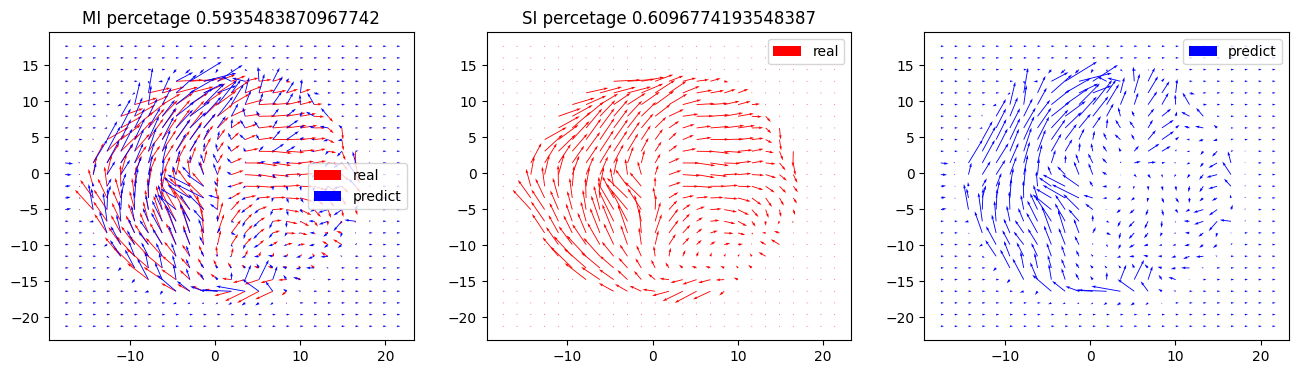

116
MI(average/percent):
0.7968309094313666 0.6096774193548387
SI(average/percent):
0.7600612161843276 0.6258064516129033
117
MI(average/percent):
0.7954790716265588 0.6161290322580645
SI(average/percent):
0.7649979178381227 0.6387096774193548
118
MI(average/percent):
0.793692000846143 0.603225806451613
SI(average/percent):
0.77185781719285 0.6483870967741936
119
MI(average/percent):
0.7916861597034204 0.6
SI(average/percent):
0.7744644355501871 0.6516129032258065
120
MI(average/percent):
0.7897490417307476 0.5870967741935483
SI(average/percent):
0.7803617361677166 0.6548387096774193


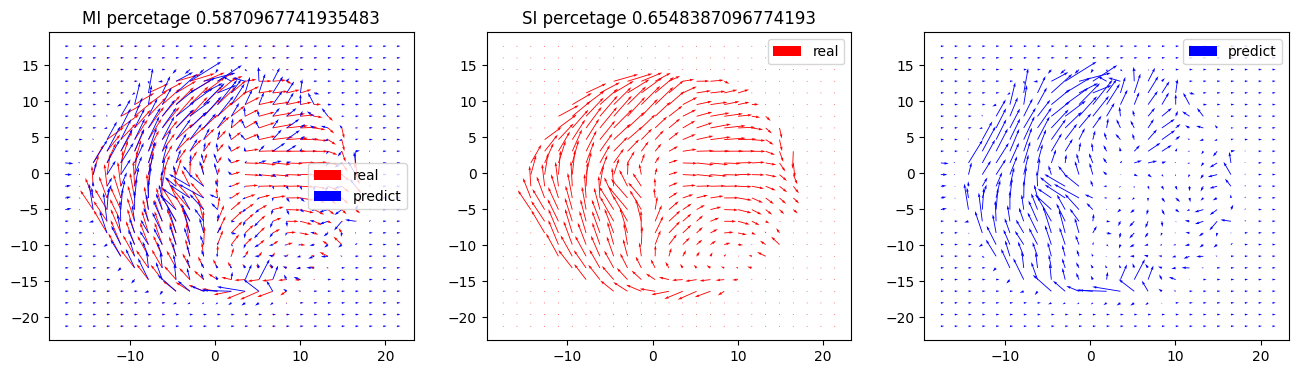

121
MI(average/percent):
0.7867963807836224 0.5806451612903226
SI(average/percent):
0.7797457247198827 0.6516129032258065
122
MI(average/percent):
0.7806639887129768 0.5774193548387097
SI(average/percent):
0.779887502984502 0.6419354838709678
123
MI(average/percent):
0.7744654916324915 0.5580645161290323
SI(average/percent):
0.779119542571699 0.6451612903225806
124
MI(average/percent):
0.7668054817643527 0.5580645161290323
SI(average/percent):
0.7797188348063612 0.6451612903225806
125
MI(average/percent):
0.759304859461884 0.5645161290322581
SI(average/percent):
0.7797147690686234 0.6451612903225806


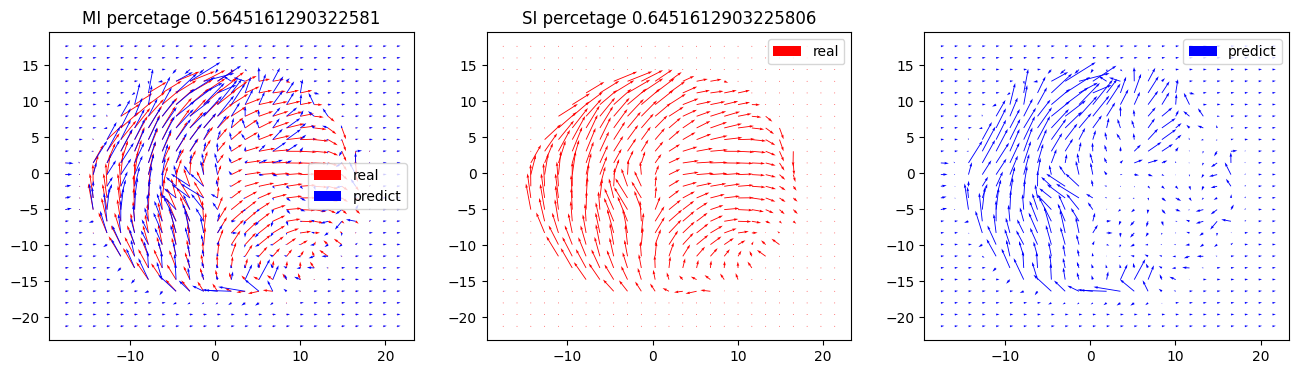

126
MI(average/percent):
0.7571825154354977 0.5612903225806452
SI(average/percent):
0.7830719203920792 0.6548387096774193
127
MI(average/percent):
0.7553159911033608 0.5580645161290323
SI(average/percent):
0.7847592263477792 0.6580645161290323
128
MI(average/percent):
0.7527320986934317 0.5645161290322581
SI(average/percent):
0.7888239313220644 0.6580645161290323
129
MI(average/percent):
0.7494907701065948 0.5548387096774193
SI(average/percent):
0.7907491692773446 0.6741935483870968
130
MI(average/percent):
0.7455421346851406 0.5451612903225806
SI(average/percent):
0.7906978621594583 0.6774193548387096


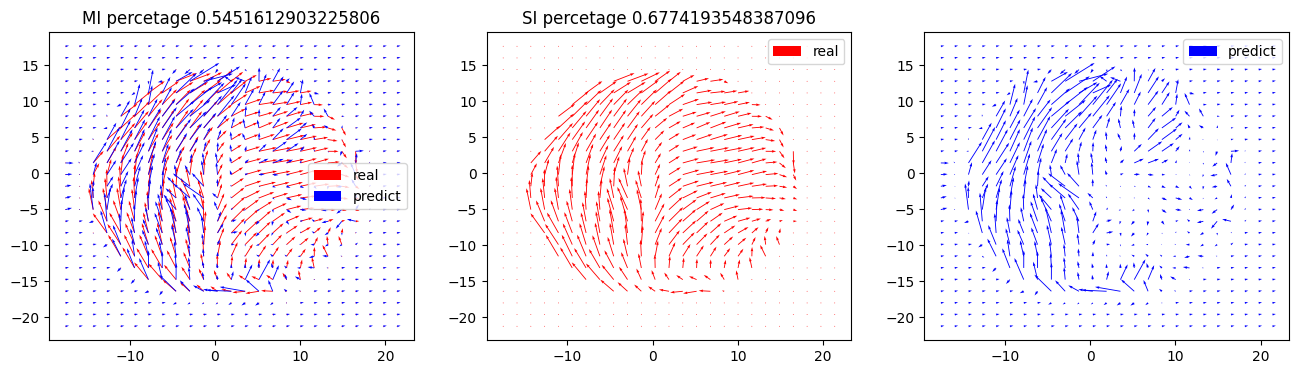

131
MI(average/percent):
0.7448200832133779 0.5516129032258065
SI(average/percent):
0.7932032194742002 0.6870967741935484
132
MI(average/percent):
0.7442051629536489 0.5548387096774193
SI(average/percent):
0.7977458335041738 0.6870967741935484
133
MI(average/percent):
0.7439824577878256 0.5516129032258065
SI(average/percent):
0.8064041276575696 0.7
134
MI(average/percent):
0.7438315948284832 0.5387096774193548
SI(average/percent):
0.8147899271804608 0.7032258064516129
135
MI(average/percent):
0.7439269547372541 0.535483870967742
SI(average/percent):
0.8223715496422705 0.7096774193548387


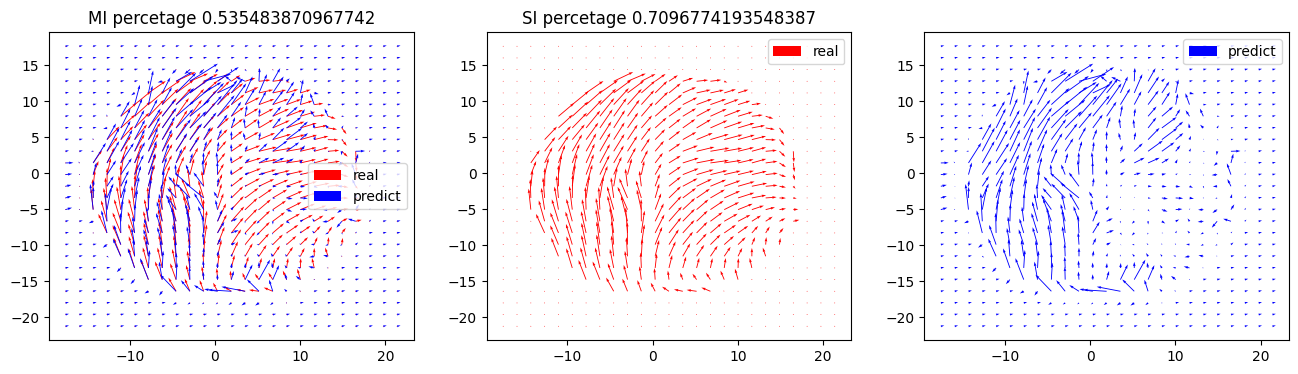

136
MI(average/percent):
0.7453592384681986 0.5451612903225806
SI(average/percent):
0.8306873487953728 0.7322580645161291
137
MI(average/percent):
0.7468836266078399 0.5451612903225806
SI(average/percent):
0.8360952767544328 0.7193548387096774
138
MI(average/percent):
0.7486162008550002 0.5516129032258065
SI(average/percent):
0.84070843494915 0.7258064516129032
139
MI(average/percent):
0.7504021306090705 0.5483870967741935
SI(average/percent):
0.8439284793046168 0.7419354838709677
140
MI(average/percent):
0.7522574804903774 0.5451612903225806
SI(average/percent):
0.8475270406895542 0.7612903225806451


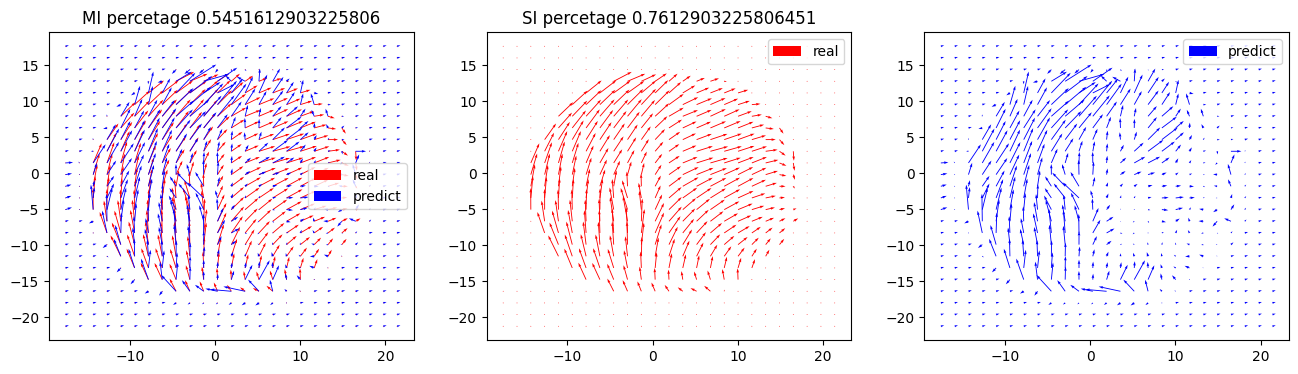

141
MI(average/percent):
0.7549705983457167 0.5451612903225806
SI(average/percent):
0.8552404265905819 0.7677419354838709
142
MI(average/percent):
0.7579151845597578 0.5516129032258065
SI(average/percent):
0.8638929801935484 0.7774193548387097
143
MI(average/percent):
0.7609785897522785 0.5548387096774193
SI(average/percent):
0.8677382119315692 0.7870967741935484
144
MI(average/percent):
0.7638379319325784 0.5548387096774193
SI(average/percent):
0.8696483391735703 0.7838709677419354
145
MI(average/percent):
0.7664373051166691 0.5612903225806452
SI(average/percent):
0.8703670430479834 0.7935483870967742


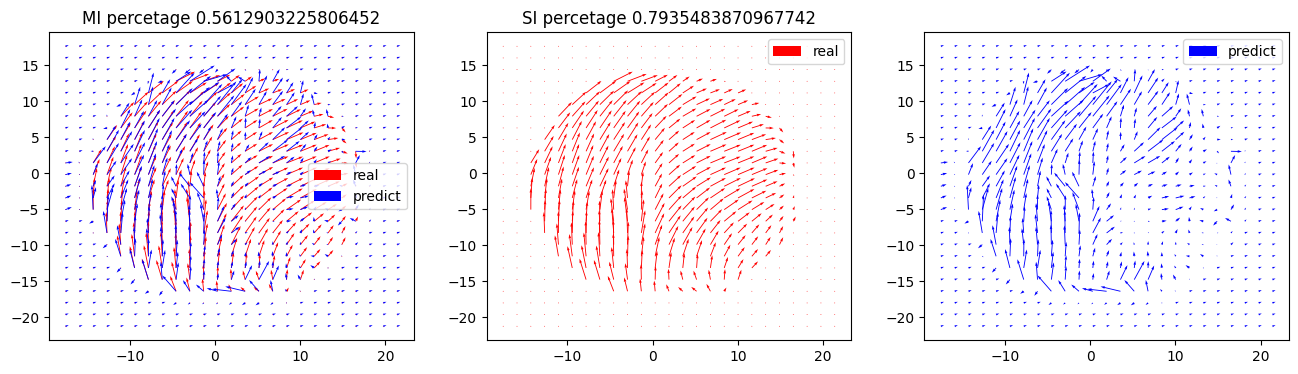

In [13]:
for i in range(p_tot):
    print(i)
    j=i
    mi_t[i],mi_t_per[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i],si_t_per[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    if i%(addp)==0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.title('MI percetage '+str(mi_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.subplot(1, 3, 2)
        plt.title('SI percetage '+str(si_t_per[i]))
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r',label='real')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.legend()
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b',label='predict')
        plt.legend()
        plt.show()
    

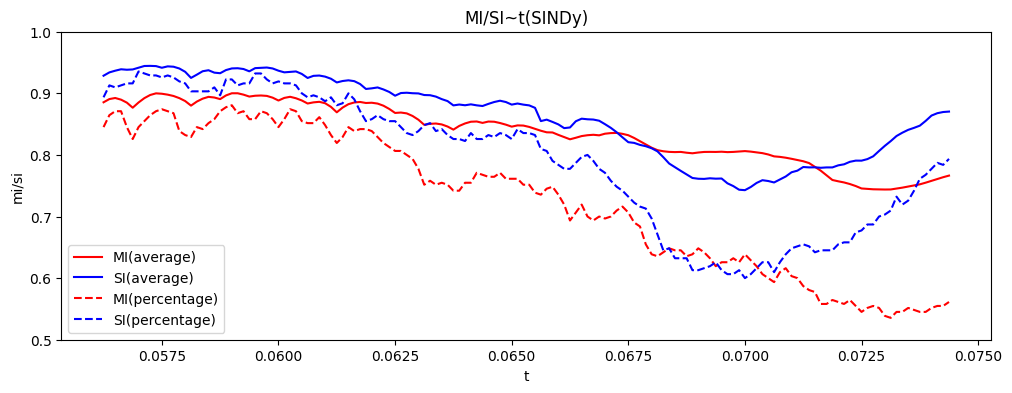

In [14]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t(SINDy)')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI(average)')
plt.plot(t_train,si_t,'b',label='SI(average)')
plt.plot(t_train,mi_t_per,'r--',label='MI(percentage)')
plt.plot(t_train,si_t_per,'b--',label='SI(percentage)')
plt.legend()
plt.ylim(0.5, 1)
plt.plot
plt.show()